In [1]:
import os
import cv2
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

### Explanation

The idea here is red lights are always going to be around red circles. Thus, we can narrow down our search to just
bounding boxes encompassing red circles in the image. Furthermore, since the size of the lights is proportional to the size of the circles, we can consider different sized bounding boxes based on the size of the circles.

### Helper functions

In [2]:
def read_im(fname, data_path='../RedLights2011_Medium'):
    # read image using PIL:
    I = Image.open(os.path.join(data_path,fname))
    # convert to numpy array:
    return np.asarray(I)


def plot_with_bounding_boxes(I, bboxes, ax=None, l_width=1):
    ''' Helper function that plots image I with bounding boxes'''
    if ax is None:
        ax = plt.subplot(111)
    
    ax.imshow(I)
    
    for bbox in bboxes:
        # Create a Rectangle patch
        x1, y1, x2, y2 = bbox
        anchor = (x2, y2)
        width = (x1 - x2)
        height = (y1 - y2)
        rect = patches.Rectangle(anchor, width, height, 
                    linewidth=l_width, edgecolor='g', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
    return ax

### Getting circles

In [3]:
def get_circles(file, filepath='../RedLights2011_Medium'):
    '''
    This function returns a list of centers and radii
    for red circles in the image given by file
    '''
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.imread(os.path.join(filepath,file))
    cimg = img
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ranges we'll consider red
    lower_red1 = np.array([0,100,100])
    upper_red1 = np.array([10,255,255])
    lower_red2 = np.array([160,100,100])
    upper_red2 = np.array([180,255,255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    maskr = cv2.add(mask1, mask2)

    m,n,_ = img.shape

    # hough circle detect
    r_circles = cv2.HoughCircles(maskr, cv2.HOUGH_GRADIENT, 1, 80,
                               param1=50, param2=10, minRadius=0, maxRadius=30)

    
    # needs to be in top bound proportion of image, since lights are high
    # usually
    bound = 4.0 / 10 
    
    centers = []
    radii = []
    
    if r_circles is not None:
        r_circles = np.uint16(np.around(r_circles))

        for (x,y,r) in r_circles[0, :]:
            # Ensure circle we're finding is in the picture
            if x > n or y > m or y > m*bound: 
                continue
            centers.append((x,y))
            radii.append(r)
            
    return centers, radii

### Detection code using circles

In [4]:
with open('filter.pkl', 'rb') as f:
    filt = pickle.load(f)

    
def detect_red_light(fname, filt=filt, thresh = 0.85, filepath='../RedLights2011_Medium'):
    '''
    This function takes a filename <fname> and returns a list <bounding_boxes>.
    The list <bounding_boxes> should have one element for each red light in the 
    image. Each element of <bounding_boxes> should itself be a list, containing 
    four integers that specify a bounding box: the row and column index of the 
    top left corner and the row and column index of the bottom right corner (in
    that order). See the code below for an example.
    
    Note that PIL loads images in RGB order, so:
    I[:,:,0] is the red channel
    I[:,:,1] is the green channel
    I[:,:,2] is the blue channel
    '''
    
    bboxes = []
    centers, radii = get_circles(fname, filepath)
    I = read_im(fname, filepath)
    m, n, _ = I.shape
    
    for (x,y), r in zip(centers, radii):
        # [1, 2] is aspect ratio, 3 is scaling since width of
        # traffic light is about 3 times the radius of the
        # actual red circle
        dims = np.array([1, 2]) * r * 3 
        anchor = (x - (dims[0] // 2), y - dims[1] // 4)
        bbox = [anchor[0], anchor[1], anchor[0] + dims[0], anchor[1] + dims[1]]
        bbox = [max(0, bbox[0]), max(0, bbox[1]),
                min(n, bbox[2]), min(m, bbox[3])]
        
        I_spliced = I[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
        pil = Image.fromarray(I_spliced)
        I2 = np.asarray(pil.resize((filt.shape[1], filt.shape[0])))
        I3 = I2 / np.linalg.norm(I2)
        if (np.sum(I3 * filt) > thresh):
            bboxes.append(bbox)
                
    for i in range(len(bboxes)):
        assert len(bboxes[i]) == 4
    
    return bboxes

Bounding boxes:  [[596, 172, 632, 244], [318, 22, 351, 88], [131, 15, 161, 75]]


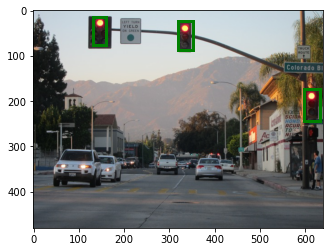

In [5]:
fname = 'RL-010.jpg'
bboxes = detect_red_light(fname)
print('Bounding boxes: ', bboxes)
plot_with_bounding_boxes(read_im(fname), bboxes, l_width=3);

### Analysis

This clearly works much better at identifying stop lights!

# SCRIPT

In [6]:
#!python3 run_predictions.py

## Visualizing script results

In [7]:
preds_path = 'hw01_preds/preds.json'
with open(preds_path, 'r') as f:
    preds = json.load(f)

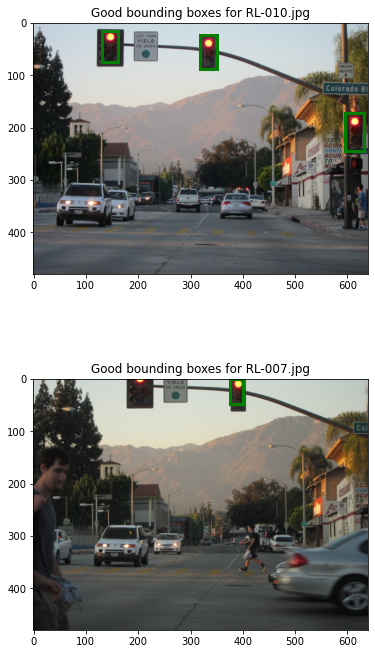

In [8]:
good_fnames = ['RL-010.jpg', 'RL-007.jpg']
n = len(good_fnames)
fig, axes = plt.subplots(n, 1, figsize=(6, 6 * n))
for i, (fname, ax) in enumerate(zip(good_fnames, axes)):
    bboxes = preds[fname]
    plot_with_bounding_boxes(read_im(fname), bboxes, l_width=3, ax=ax)
    ax.set_title(f'Good bounding boxes for {fname}')
    # Save just the portion around the second axis's boundaries
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'good_{i+1}.png', bbox_inches=extent.expanded(1.2, 1.2))

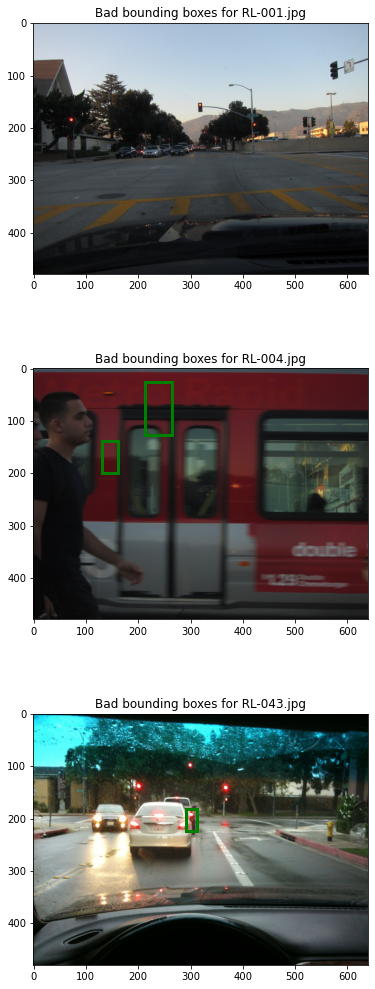

In [9]:
bad_fnames = ['RL-001.jpg', 'RL-004.jpg', 'RL-043.jpg']
n = len(bad_fnames)
fig, axes = plt.subplots(n, 1, figsize=(6, 6 * n))
for i, (fname, ax) in enumerate(zip(bad_fnames, axes)):
    bboxes = preds[fname]
    plot_with_bounding_boxes(read_im(fname), bboxes, l_width=3, ax=ax)
    ax.set_title(f'Bad bounding boxes for {fname}')
    # Save just the portion around the second axis's boundaries
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'bad_{i+1}.png', bbox_inches=extent.expanded(1.2, 1.2))